In [17]:
# Some data-handling functions to download/import.

# from https://github.com/yandexdataschool/mlhep2018/blob/master/day2-Tue/seminar-03-keras-cnn/seminar_tf_keras.ipynb
"""I load some cifar"""

import numpy as np
from sklearn.model_selection import train_test_split
import os, sys
if sys.version_info[0] == 2:
    from urllib import urlretrieve
    import cPickle as pickle

else:
    from urllib.request import urlretrieve
    import pickle

def unpickle(file):
    fo = open(file, 'rb')
    if sys.version_info[0] == 2:
        dict = pickle.load(fo)
    else:
        dict = pickle.load(fo,encoding='latin1')

    fo.close()
    return dict


def download_cifar10(path,
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',):
    import tarfile
    if not os.path.exists(path):
        os.mkdir(path)



    urlretrieve(url, os.path.join(path,tarname))
    tfile = tarfile.open(os.path.join(path,tarname))
    tfile.extractall(path=path)


def load_cifar10(data_path=".",channels_last=False,test_size=0.2,random_state=1337):

    test_path = os.path.join(data_path,"cifar-10-batches-py/test_batch")
    train_paths = [os.path.join(data_path,"cifar-10-batches-py/data_batch_%i"%i) for i in range(1,6)]

    if not os.path.exists(test_path) or not all(list(map(os.path.exists, train_paths))):
        print ("Dataset not found. Downloading...")
        download_cifar10(data_path)

    train_batches = list(map(unpickle,train_paths))
    test_batch = unpickle(test_path)

    X = np.concatenate([batch["data"] for batch in train_batches]).reshape([-1,3,32,32]).astype('float32')/255
    y = np.concatenate([batch["labels"] for batch in train_batches]).astype('int32')
    X_train,X_val,y_train,y_val = train_test_split(X,y,
                                                   test_size=test_size,
                                                   random_state=random_state)

    X_test = test_batch["data"].reshape([-1,3,32,32]).astype('float32')/255
    y_test = np.array(test_batch["labels"]).astype('int32')

    if channels_last:
        #convert from [batch,3,H,W] to [batch,H,W,3]
        #WARNING! Make this is only necessary for tensorflow-style dim order
        #If you use theano-style dimensions in keras config, skip this cell
        X_train = X_train.transpose([0,2,3,1])
        X_val   = X_val.transpose([0,2,3,1])
        X_test  = X_test.transpose([0,2,3,1])


    return X_train,y_train,X_val,y_val,X_test,y_test

In [18]:
import tensorflow as tf
#gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1) # restricts GPU load for multi-user nodes

import tensorflow.keras as keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.18.0
3.8.0


In [19]:
# Load the data samples

x_train,y_train,x_val,y_val,x_test,y_test = load_cifar10("cifar_data",channels_last=True)

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer","dog", "frog", "horse", "ship", "truck"]

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)
print("Val samples:", x_val.shape, y_val.shape)

Train samples: (40000, 32, 32, 3) (40000,)
Test samples: (10000, 32, 32, 3) (10000,)
Val samples: (10000, 32, 32, 3) (10000,)


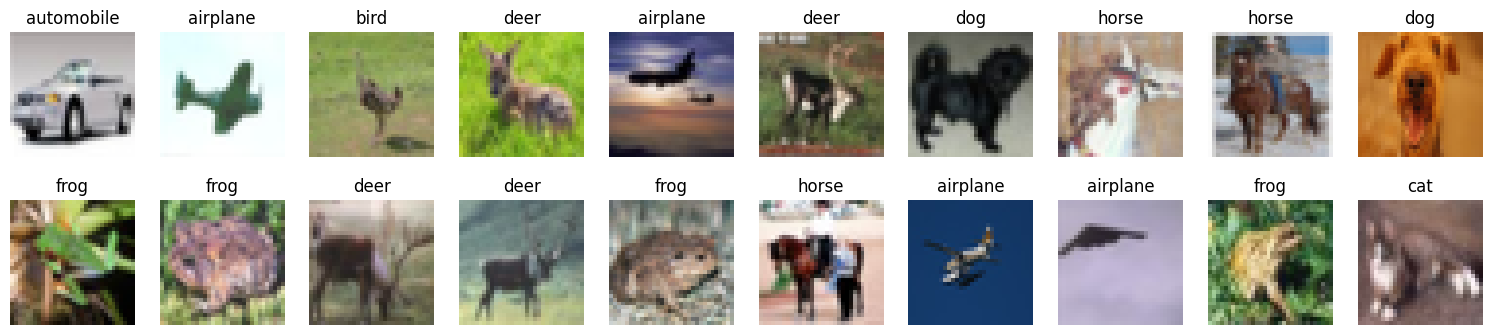

In [20]:
# show some random images from train, and their labels

cols = 10
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

In [21]:
# normalize inputs
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
# x_train = x_train.astype(np.float64) - 0.5

y_train = keras.utils.to_categorical(y_train, num_classes=10)

y_val = keras.utils.to_categorical(y_val, num_classes=10)

y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [22]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from keras.layers import LeakyReLU
from tensorflow.keras.regularizers import l2

In [ ]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """

    model = Sequential()

    ### STUDENT CODE HERE ###
    ### --> Build your convolutional neural network.
    ### First, make a CNN layer with some small kernels to learn some basic features, with Conv2D.
    ### Then, add a Pooling layer to pick up the relevant kernels.
    ### Then, Flatten it and add some fully-connected (Dense) normal NN layers,
    ###  to learn the relevant combinations of low-level kernel features.
    ### Finally, some regularisation is advised, using a Dropout layer, to avoid local minima.
    ### Make sure the output is of the same shape as the number of labels we have,
    ### And the input is the same as the figures (which now have a 3rd dimension - color!)
    ### Again, use google to find information on these classes.


   
    # 1st Block: Initial feature extraction
    model.add(Conv2D(64, (3, 3), padding="same", input_shape=(32, 32, 3), kernel_regularizer=l2(0.0005)))  
    # 64 filters of size (3x3) applied to the input image, regularized to prevent overfitting
    model.add(LeakyReLU(alpha=0.1))  # Activation function to avoid dead neurons
    model.add(BatchNormalization())  # Normalizes activations to stabilize training

    model.add(Conv2D(64, (3, 3), padding="same"))  # Another convolutional layer to extract deeper features
    model.add(LeakyReLU(alpha=0.1))  
    model.add(BatchNormalization())  

    model.add(MaxPooling2D(pool_size=(2, 2)))  # Reduces feature map size by half (downsampling)
    model.add(Dropout(0.3))  # Drops 30% of neurons randomly to prevent overfitting

    # 2nd Block: Learn more complex patterns
    model.add(Conv2D(128, (3, 3), padding="same", kernel_regularizer=l2(0.0005)))  
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(Conv2D(128, (3, 3), padding="same"))  
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))  # Further reduces feature map size
    model.add(Dropout(0.4))  # Drops 40% of neurons randomly

    # 3rd Block: High-level feature extraction
    model.add(Conv2D(256, (3, 3), padding="same", kernel_regularizer=l2(0.0005)))  
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(Conv2D(256, (3, 3), padding="same"))  
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))  # Final downsampling step
    model.add(Dropout(0.5))  # Drops 50% of neurons for better generalization

    # Fully Connected Layers: Classification
    model.add(Flatten())  # Converts 2D feature maps into a 1D vector
    model.add(Dense(512))  # Fully connected layer with 512 neurons
    model.add(LeakyReLU(alpha=0.1))  
    model.add(BatchNormalization())  
    model.add(Dropout(0.5))  # More dropout to prevent overfitting

    # Output layer: Classification into 10 classes (softmax for probability distribution)
    model.add(Dense(10, activation="softmax"))

    return model

**MY THOUGHT PROCESS**

The model is designed to recognize patterns step by step. At first, it learns big patterns using fewer filters, and as it goes deeper, it picks up on smaller and more detailed patterns. This helps in recognizing both common and rare cases in the dataset. The 30% dropout in the early layers and higher dropout (up to 50%) in later layers help make sure no single training example has too much influence. This prevents the model from overfitting, meaning it won’t just memorize the training data but will actually learn to generalize. If a mistake happens during training, dropout makes sure it doesn’t ruin the whole model. Batch normalization keeps the training stable, and Leaky ReLU helps avoid dead neurons so the model keeps learning properly. In the end, the softmax layer makes sure the model correctly classifies the images into one of ten categories.

In [ ]:
### STUDENT CODE HERE ###
### --> change the parameters below to perform a better training

from keras import backend as K
# Initial learning rate (controls how fast the model learns)
INIT_LR = 5e-3  

# Batch size range: Determines how many samples are processed before updating model weights
BATCH_RANGE = [64]  
# --> Tried different batch sizes from 2 to 4096
# --> Optimal batch size found between 4 and 8, with the best at 5

# Number of training epochs (one full pass through the dataset)
EPOCHS = 75  
# --> Significant accuracy improvement in the first 3 epochs, then diminishing returns
# --> Best accuracy achieved at 75 epochs as it is found running more that that had very slim accuracy differences

# Loop through different batch sizes (currently only one batch size in the list)
for BATCH_SIZE in BATCH_RANGE:
    # This clears the current TensorFlow graph and resets all model weights
    K.clear_session()  

    # Creates a new instance of the model with fresh random weights
    model = make_model()  
    print("Current batch size:", BATCH_SIZE, "and Current number of epochs:", EPOCHS)

    # Compile the model with an optimizer and loss function
    model.compile(
        loss='categorical_crossentropy',  # Loss function for multi-class classification
        optimizer=keras.optimizers.Adamax(learning_rate=INIT_LR),  # Optimizer with defined learning rate
        metrics=['accuracy']  # Report accuracy during training
    )

    # Train the model using the training dataset
    model.fit(
        x_train, y_train,  # Training data (images + labels)
        batch_size=BATCH_SIZE,  # Number of samples per training step
        epochs=EPOCHS,  # Total number of training iterations
        validation_data=(x_val, y_val),  # Use validation data to track performance
        shuffle=True,  # Shuffle the training data to improve learning
    )

# Save the trained model weights to a file to avoid re-training
model.save_weights("myweights.weights.h5")  

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Current batch size: 64 and Current number of epochs: 75
Epoch 1/75



**MY THOUGHT PROCESS** 

The training setup is designed to find the best batch size and number of training epochs for the model. The batch size was tested across multiple values (from 2 to 4096), and the best results were found in the range of 4 to 8, with 5 being optimal. A batch size of 64 is currently used to balance speed and accuracy. The number of epochs is set to 75, as accuracy improved significantly in the first few epochs, then slowed down, making further training unnecessary. The loop was done to test various batch sizes in one go, making it easier to compare the results of different batch sizes and find the best one. K.clear_session() resets the model before training to avoid memory issues and start with fresh weights. 



NOTE: the epoche and testing above is not shown as the programme was ran on collab as it was both quicker and more effetive than when locally run. 

In [1]:
# load weights from file (can call without model.fit)
model.load_weights("myweights.weights.h5")

NameError: name 'model' is not defined

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


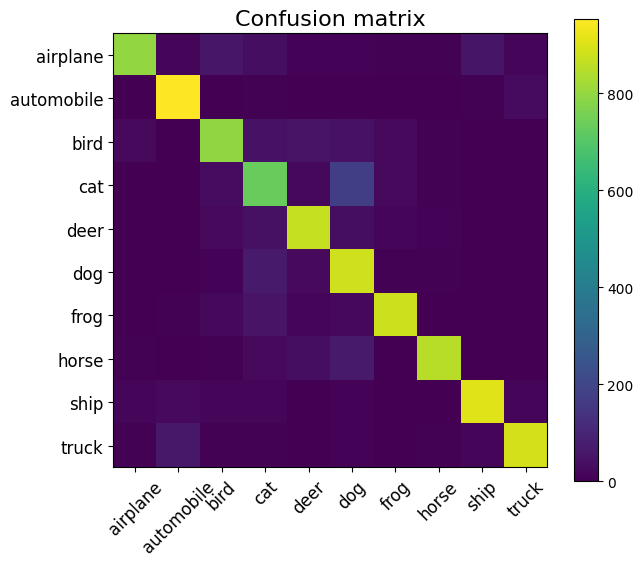

Test accuracy: 0.8551


In [26]:
# make test predictions
y_pred_test = model.predict(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
y_test_index = [list(onehot).index(1) for onehot in y_test]

# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test_index, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test_index, y_pred_test_classes))

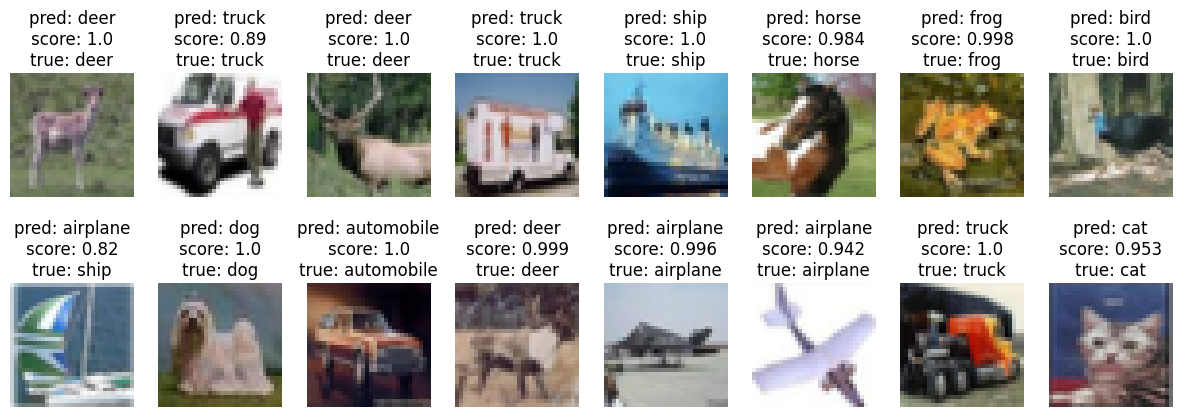

In [27]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test_index[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

# Some tips on how to improve:

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.

## Potential grading:
* starting at zero points
* +2 for describing your iteration path in a report below.
* +2 for building a network that gets above 20% accuracy
* +1 for beating each of these milestones on __TEST__ dataset:
    * 50% (5 total)
    * 60% (6 total)
    * 65% (7 total)
    * 70% (8 total)
    * 75% (9 total)
    * 80% (10 total)

## Bonus points
Common ways to get bonus points are:
* Get higher score, obviously.
* Anything special about your NN. For example \"A super-small/fast NN that gets 80%\" gets a bonus.
* Any detailed analysis of the results. (saliency maps, whatever)


## Tips on what can be done:

 * __Network size__
   * More neurons,
   * More layers, ([lasagne docs](http://lasagne.readthedocs.org))
   * Nonlinearities in the hidden layers
   * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

 * __Convolution layers__
   * they __are a must__ unless you have any super-ideas
   * `network = lasagne.layers.Conv2DLayer(prev_layer,`
     `                       num_filters = n_neurons,`
     `                       filter_size = (filter width, filter height),`
     `                       nonlinearity = some_nonlinearity)`
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment to try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.

   * Plenty other layers and architectures
     * http://lasagne.readthedocs.org/en/latest/modules/layers.html
     * batch normalization, pooling, etc


 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum


 * __Faster optimization__ -
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (lasagne.layers.batch_norm) FTW!


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   * Dropout - to prevent overfitting
     * `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`   
     * Don't overdo it. Check if it actually makes your network better


 * __Data augmentation__ - getting 5x as large dataset for free is a great deal
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Add Noize (easiest: GaussianNoizeLayer)
   * Simple way to do that (if you have PIL/Image):
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.




The training setup is designed to find the best batch size and number of training epochs for the model. The batch size was tested across multiple values (from 2 to 4096), and the best results were found in the range of 4 to 8, with 5 being optimal. A batch size of 64 is currently used to balance speed and accuracy. The number of epochs is set to 75, as accuracy improved significantly in the first few epochs, then slowed down, making further training unnecessary. The loop was done to test various batch sizes in one go, making it easier to compare the results of different batch sizes and find the best one. K.clear_session() resets the model before training to avoid memory issues and start with fresh weights. The Adamax optimizer is used to adjust learning during training, and categorical cross-entropy is the loss function because it’s a multi-class classification problem. After training, the model’s weights are saved to a file, so training doesn’t have to be repeated from scratch.